In [2]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [3]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [86]:
def create_graphs(tcols=[0,2,4,5,6,7,8,10,28], percentile=50, target=8, lim=10.5, save=False, case='test', transform='quantile', maxs=[1,1,1]):
    dat=[]
    tcols=np.array(tcols)
    raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
    scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols]
    
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                start=time.time()
                print(f'Loading isotree {i}_{j}_{k}')
                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')
                
                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1
                
                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw
                
                ##########################################
                ### End loading, begin dtype changing  ###
                ##########################################
                
                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)
                
                ###################################################
                ### end dtype, begin inital hardcoded scaling   ###
                ###################################################
                
                ## initial scaling
                hard=[0,2,15]
                def logit(x):
                    return np.log10((x+0.001)/(1.01-x))
                ##logit transform the hards
                for h in hard:
                    if h in tcols:
                        h1=np.where(load_cols==h)[0][0]+1
                        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                log=[10,38, 39, 40, 41, 42]
                #simple log for the rest
                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])

                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                del halos
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                for tree in splits:
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    for n in scale_cols:
                        n1=np.where(load_cols==n)[0][0]
                        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
                    split.append(s)
                split=np.array(split, dtype=object)
                print('Split done')
                print('Loading targets')
                ex=f'{i}_{j}_{k}/galprop_0-99.dat'
                pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
                newcols=pdc.iloc[:,0]
                pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
                pds.columns=np.array(newcols)
                pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
                pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

                rhalid=np.array(pdcen[pds.columns[2]])
                del pd0
                del pds
                halwgal=[]
                ids=[]
                out=[]
                for idx, tree in enumerate(split): #split up into tree
                    if tree[0,1] in rhalid:
                        if len(tree)>20000:
                            print(len(tree))
                        else:
                            halwgal.append(tree)
                            ids.append(idx)
                            index=np.where(rhalid==tree[0,1])
                            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
                del pdcen

                hraw=np.array(splits[ids], dtype=object)
                hals=[]
                pr,de=[],[]
                discards=[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    discarded=[]
                    for mid in mergers[:,1]:
                        k=1
                        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
                        while descid not in mergers[:,1] and descid!=-1: 
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                        pro.append(mid)
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                        k=1
                        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                        pro.append(r[1])
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    discards.append(np.array(discarded))
                    des,pro=convert(des, pro)
                    hal2=np.vstack([final,mergers,roots])
                    global mass_index
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                        mask=np.array([bool(i) for i in not_include])
                        idcols=load_cols[~mask] ##choose non-id cols to carry forward
                        mass_id=np.where(np.array(idcols)==10)[0][0]
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                hals=np.array(hals,dtype=object)
                out=np.log10(out) #homemade scaling
                masks=[]
                for n in tqdm(range(len(out))):
                    mask=hals[n][:,0]>np.percentile(hals[n][:,0], 50)
                    masks.append(mask)
                    desc, progs = convert(list(np.array(de[n])[mask[1:]]), list(np.array(pr[n])[mask[1:]]) )
                    edge_index = torch.tensor([progs, desc], dtype=torch.long)
                    x = torch.tensor(hals[n][mask], dtype=torch.float)
                    y=torch.tensor(out[n], dtype=torch.float)
                    edge_attr=torch.tensor(discards[n][mask[1:]], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
    if save:
        print("Saving dataset")
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)
    return dat

In [93]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
# all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,25,35]+list(range(37,60)))
# all_cols=np.array([0,2,4,10])
maxs=[2,3,3]
for percentile in tqdm([80,50,25,15,10], total=5):
    dat=create_graphs(tcols=all_cols, percentile=percentile, maxs=maxs, lim=10, save=1, case=f'{np.prod(maxs)}_redshift_{percentile}_all')

  0%|                                                                         | 0/5 [00:00<?, ?it/s]

Loading isotree 0_0_0


/tmp/ipykernel_21062/2804478738.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, percentile=percentile, maxs=maxs, lim=10, save=1, case=f'{np.prod(maxs)}_redshift_{percentile}_all')


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree



 85%|███████████████████████████████████████████████████▎        | 657/769 [00:52<00:00, 150.38it/s]


100%|█████████████████████████████████████████████████████████████| 769/769 [00:52<00:00, 14.52it/s]

100%|███████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 1033.16it/s]


Done with tree. 
 Time elapsed 154.41472387313843 s
Loading isotree 0_0_1


/tmp/ipykernel_21062/2804478738.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, percentile=percentile, maxs=maxs, lim=10, save=1, case=f'{np.prod(maxs)}_redshift_{percentile}_all')


isotree 0_0_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree



 40%|███████████████████████▋                                    | 529/1338 [01:40<00:51, 15.77it/s]


100%|███████████████████████████████████████████████████████████| 1338/1338 [02:49<00:00,  7.88it/s]

100%|██████████████████████████████████████████████████████████| 1338/1338 [00:01<00:00, 758.56it/s]


Done with tree. 
 Time elapsed 347.56426763534546 s
Loading isotree 0_0_2


/tmp/ipykernel_21062/2804478738.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, percentile=percentile, maxs=maxs, lim=10, save=1, case=f'{np.prod(maxs)}_redshift_{percentile}_all')


isotree 0_0_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
72404
60368
26084
29167
Making merger tree



 43%|█████████████████████████▉                                  | 636/1472 [02:22<06:11,  2.25it/s]


 72%|█████████████████████████████████████████▍                | 1053/1472 [02:36<00:03, 132.39it/s]


100%|███████████████████████████████████████████████████████████| 1472/1472 [02:38<00:00,  9.26it/s]

100%|██████████████████████████████████████████████████████████| 1472/1472 [00:01<00:00, 875.66it/s]


Done with tree. 
 Time elapsed 380.03223943710327 s
Loading isotree 0_1_0


/tmp/ipykernel_21062/2804478738.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, percentile=percentile, maxs=maxs, lim=10, save=1, case=f'{np.prod(maxs)}_redshift_{percentile}_all')


isotree 0_1_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
70472
Making merger tree



 53%|███████████████████████████████▌                            | 593/1127 [01:13<00:54,  9.86it/s]


100%|███████████████████████████████████████████████████████████| 1127/1127 [02:25<00:00,  7.76it/s]

100%|██████████████████████████████████████████████████████████| 1127/1127 [00:01<00:00, 712.86it/s]


Done with tree. 
 Time elapsed 318.1690170764923 s
Loading isotree 0_1_1


/tmp/ipykernel_21062/2804478738.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, percentile=percentile, maxs=maxs, lim=10, save=1, case=f'{np.prod(maxs)}_redshift_{percentile}_all')


isotree 0_1_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
70115
52207
43321
25280
381538
Making merger tree



 20%|███████████▊                                              | 394/1932 [02:11<1:07:16,  2.62s/it]


  0%|                                                                         | 0/5 [34:14<?, ?it/s]


KeyboardInterrupt: 

In [91]:
m=[2,3,3]
np.prod(m)

18

In [89]:
xs=[]
ls=[]
ks=[]
for d in dat:
    xs.append(d.x.numpy())
    ls.append(len(d.x.numpy()))
    ks.append(1/np.array(d.edge_attr))
xs=np.vstack(xs)
ks=np.hstack(ks)

In [99]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,24,25,35]+list(range(37,60)))

target=8
lim=11
case='test'
transform='quantile'
maxs=[1,1,1]
dat=[]
tcols=np.array(all_cols)
raw_path='../../../../tigress/mcranmer/merger_trees/isotrees/'
target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
transform_path=f'../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) 
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3])
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]
start=time.time()
for i in range(0, maxs[0]):
    for j in range(0,maxs[1]):
        for k in range(0, maxs[2]):
            print(f'Loading isotree {i}_{j}_{k}')
            pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
            print(f'isotree {i}_{j}_{k} loaded, restructuring')

            raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
            del pd1

            trees=raw[raw.isna()['desc_id(3)']] 
            halos=raw[~raw.isna()['desc_id(3)']]
            del raw
 



Loading isotree 0_0_0
isotree 0_0_0 loaded, restructuring


In [104]:
mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
k=0
for l in load_cols:
    k+=1
    if l<25:
        map1.append(l)
        map2.append(k)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

25 [ 0  1  2  3  4  6  7  8 10 11 12 13 14 15 16 17 18 19 22 23 24] 21


{'#scale(0)': 'float64',
 'id(1)': 'int64',
 'desc_scale(2)': 'float64',
 'desc_id(3)': 'int64',
 'num_prog(4)': 'int64',
 'upid(6)': 'int64',
 'desc_pid(7)': 'int64',
 'phantom(8)': 'int64',
 'Mvir(10)': 'float64',
 'Rvir(11)': 'float64',
 'rs(12)': 'float64',
 'vrms(13)': 'float64',
 'mmp?(14)': 'int64',
 'scale_of_last_MM(15)': 'float64',
 'vmax(16)': 'float64',
 'x(17)': 'float64',
 'y(18)': 'float64',
 'z(19)': 'float64',
 'vz(22)': 'float64',
 'Jx(23)': 'float64',
 'Jy(24)': 'float64'}

In [52]:
tcols=[0,2,4,5,6,7,8,10]
target=8
lim=10
save=0
case='test'
transform='quantile'
maxs=[1,1,1]
i,j,k=0,0,0
dat=[]
tcols=np.array(tcols)
raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) 
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3])
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]


start=time.time()
print(f'Loading isotree {i}_{j}_{k}')
pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
print(f'isotree {i}_{j}_{k} loaded, restructuring')

raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
del pd1

trees=raw[raw.isna()['desc_id(3)']] 
halos=raw[~raw.isna()['desc_id(3)']]
del raw

##########################################
### End loading, begin dtype changing  ###
##########################################

mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
q=0
for l in load_cols:
    q+=1
    if l<25:
        map1.append(l)
        map2.append(q)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

###################################################
### end dtype, begin inital hardcoded scaling   ###
###################################################

## initial scaling
hard=[0,2,15]
def logit(x):
    return np.log10((x+0.001)/(1.01-x))
##logit transform the hards
for h in hard:
    if h in tcols:
        h1=np.where(load_cols==h)[0][0]+1
        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

log=[10,38, 39, 40, 41, 42]
#simple log for the rest
def logt(x):
    return np.log10(x+1)
for l in log:
    if l in tcols:
        l1=np.where(load_cols==l)[0][0]+1
        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

scale_cols=np.array(tcols[~is_cat[tcols]])

print(f'Splitting to tree and scaling')
spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
del halos
splits=[]
for s in spli:
    if s[0,np.where(load_cols==10)[0][0]]>lim:
        splits.append(s)
splits=np.array(splits, dtype=object)
split=[]
for tree in splits:
    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
    for n in scale_cols:
        n1=np.where(load_cols==n)[0][0]
        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
    split.append(s)
split=np.array(split, dtype=object)
print('Split done')
print('Loading targets')
ex=f'{i}_{j}_{k}/galprop_0-99.dat'
pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
newcols=pdc.iloc[:,0]
pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
pds.columns=np.array(newcols)
pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

rhalid=np.array(pdcen[pds.columns[2]])
del pd0
del pds
halwgal=[]
ids=[]
out=[]
for idx, tree in enumerate(split): #split up into tree
    if tree[0,1] in rhalid:
        if len(tree)>20000:
            print(len(tree))
        else:
            halwgal.append(tree)
            ids.append(idx)
            index=np.where(rhalid==tree[0,1])
            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
del pdcen

hraw=np.array(splits[ids], dtype=object)

Loading isotree 0_0_0


/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets


In [84]:
dat=[]
hals=[]
pr,de=[],[]
discards=[]
print('Making merger tree')
for n in tqdm(range(len(halwgal))):
    h=halwgal[n]
    roots=h[h[:,4]==0]
    mergers=h[h[:,4]>1]
    final=h[h[:,3]==-1]
    pro, des=[],[]
    discarded=[]
    for mid in mergers[:,1]:
        k=1
        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
        while descid not in mergers[:,1] and descid!=-1: 
            k+=1
    
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
        pro.append(mid)
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
        discarded.append(1/k) 

    for r in roots:
        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
        k=1
        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
            k+=1
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
        pro.append(r[1])
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
        discarded.append(1/k) 

    discards.append(np.array(discarded))
    des,pro=convert(des, pro)
    hal2=np.vstack([final,mergers,roots])
    global mass_index
    if n==0:
        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
        mask=np.array([bool(i) for i in not_include])
        idcols=load_cols[~mask] ##choose non-id cols to carry forward
        mass_id=np.where(np.array(idcols)==10)[0][0]
    hal2=hal2[:,fcols] ##take away id's
    hals.append(hal2)
    pr.append([int(p) for p in pro])
    de.append([int(d) for d in des])
hals=np.array(hals,dtype=object)
# out=np.log10(out) #homemade scaling
masks=[]
for n in tqdm(range(len(out))):
    mask=hals[n][:,0]>np.percentile(hals[n][:,0], 50)
    masks.append(mask)
    desc, progs = convert(list(np.array(de[n])[mask[1:]]), list(np.array(pr[n])[mask[1:]]) )
    edge_index = torch.tensor([progs, desc], dtype=torch.long)
    x = torch.tensor(hals[n][mask], dtype=torch.float)
    y=torch.tensor(out[n], dtype=torch.float)
    edge_attr=torch.tensor(discards[n][mask[1:]], dtype=torch.float)
    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    dat.append(graph)
stop=time.time()
print(f'Done with tree. \n Time elapsed {stop-start} s')
if save:
    print("Saving dataset")
    if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
        os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

    with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
        pickle.dump(dat, handle)

Making merger tree


100%|███████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 1218.36it/s]

Done with tree. 
 Time elapsed 2046.185875415802 s


In [58]:
case='test_cut'
print("Saving dataset")
if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
    os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
    pickle.dump(dat, handle)

Saving dataset


In [54]:
diff1=[]
diff2=[]
for n in range(len(masks)):
    diff1.append(len(masks[n])-np.sum(masks[n]))
    diff2.append(len(dat[n].x.numpy())-np.sum(masks[n]))
    

In [77]:
convert(list(np.array(de[n])[mask[1:]]), list(np.array(pr[n])[mask[1:]]) ) 

([0, 1, 2, 3, 4, 5, 1], array([1, 2, 3, 4, 5, 6, 7]))

In [72]:
a,b=np.array(dat[j].edge_index)
a,b

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        24, 45, 46, 47, 50, 51, 52, 53, 54, 55]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 10, 10,  9,  6,  5,  4,  3,  2,  1]))

In [75]:
convert(list(b),list(a))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  10,
  10,
  9,
  6,
  5,
  4,
  3,
  2,
  1],
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27]))

Made graph
drawing


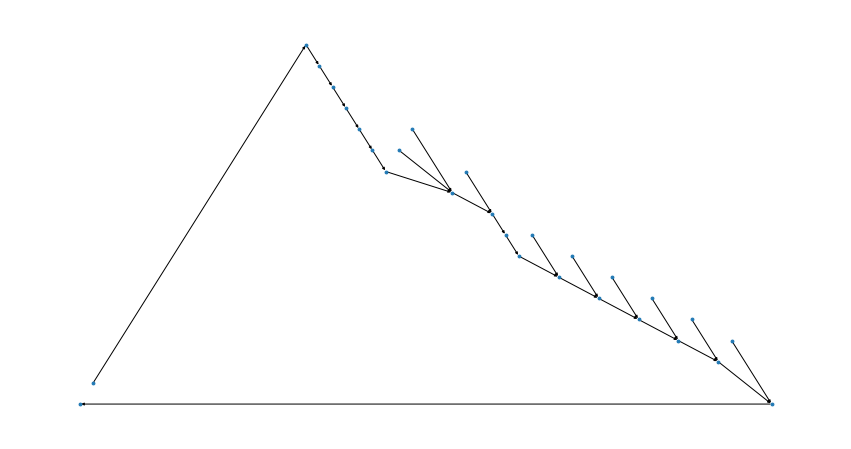

In [85]:
#graph 275

j=0
from matplotlib import cm
cmap=cm.get_cmap(name='magma')
fig,ax=plt.subplots(figsize=(15,8))
dat[j].num_nodes=len(dat[j].x.numpy()[:,0])
G=tg.utils.to_networkx(dat[j])
di=nx.betweenness_centrality(G)
# for q,key in enumerate(di.keys()):
#     di[key]=dat[j].x.numpy()[q,2]
# nx.set_node_attributes(G, di, 'n_prog')
for q,key in enumerate(di.keys()):
    di[key]=dat[j].x.numpy()[q,0]
nx.set_node_attributes(G, di, 'scale')
print('Made graph')
# G.remove_nodes_from(list(nx.isolates(G)))
pos=nx.planar_layout(G)
# pos=nx.kamada_kawai_layout(G) #this one is kinda snakey but works pretty well! Slow as hell though
if G.number_of_nodes()<2000:
    print('drawing')
    nx.draw(G, pos=pos,ax=ax, node_size=8, arrowsize=5, cmap=cmap)

In [82]:
len(dat[j].edge_index[0])

7

In [65]:
np.shape(dat[0].x.numpy()), len(di.keys())

((28, 4), 37)

In [ ]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
fig,ax=plt.subplots(figsize=(25,12))
# get unique groups
groups = set(nx.get_node_attributes(G,'n_prog').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors=dat[j].x.numpy()[:,2]
sizes=(dat[j].x.numpy()[:,3]-min(dat[j].x.numpy()[:,3])+1)**2
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.planar_layout(G)
ec = nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=nodes, node_color=colors, node_size=sizes, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [8]:
g=dat[0]

In [15]:
mask=g.x.numpy()[:,0]>np.percentile(g.x.numpy()[:,0], 50)

In [16]:
g.x.numpy()[mask]

array([[ 5.1993375 , -5.1993375 ,  1.        ,  1.2592287 ],
       [ 2.5117912 ,  5.1993375 ,  2.        ,  1.2612058 ],
       [ 2.2899878 ,  2.5754833 ,  2.        ,  1.2837633 ],
       [ 1.792374  ,  1.8658521 ,  2.        ,  1.3285646 ],
       [ 1.6896701 ,  1.7560546 ,  2.        ,  1.3382151 ],
       [ 1.5417962 ,  1.5932188 ,  2.        ,  1.3610182 ],
       [ 1.521525  ,  1.5712864 ,  2.        ,  1.3581429 ],
       [ 1.4752693 ,  1.521525  ,  2.        ,  1.355696  ],
       [ 1.4532796 ,  1.4979966 ,  2.        ,  1.353236  ],
       [ 1.4319708 ,  1.4715548 ,  2.        ,  1.3500606 ],
       [ 1.1844468 ,  1.2206403 ,  3.        ,  1.3125271 ],
       [ 1.1570615 ,  1.1920714 ,  2.        ,  1.3100166 ],
       [ 0.77483284,  0.7987689 ,  2.        ,  1.2469034 ],
       [ 0.7364425 ,  0.75800425,  2.        ,  1.2348161 ],
       [ 0.69431055,  0.71521777,  3.        ,  1.2231706 ],
       [ 0.3884302 ,  0.4074416 ,  2.        ,  1.1559807 ],
       [ 0.324254  ,  0.

In [27]:
fro, to = g.edge_index

In [28]:
fro, to

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
         55]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 17, 15, 22, 23, 23, 23, 21, 20, 19, 19, 18, 24, 24,
         16, 25, 25, 14, 14, 13, 12, 11, 10, 10,  9,  8,  7,  6,  5,  4,  3,  2,
          1]))

In [40]:
to[mask[:-1]], fro[mask[:-1]]

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         15, 10,  9,  8,  5,  4,  3,  2,  1]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         25, 46, 47, 48, 51, 52, 53, 54, 55]))

In [43]:
to[mask[1:]], fro[mask[1:]]

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         10, 10,  9,  6,  5,  4,  3,  2,  1]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 24,
         45, 46, 47, 50, 51, 52, 53, 54, 55]))

In [39]:
to, fro

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 17, 15, 22, 23, 23, 23, 21, 20, 19, 19, 18, 24, 24,
         16, 25, 25, 14, 14, 13, 12, 11, 10, 10,  9,  8,  7,  6,  5,  4,  3,  2,
          1]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
         55]))

In [36]:
np.arange(1,56)[mask[1:]]==np.array(fro[mask[1:]])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [41]:
np.shape(g.x)

torch.Size([56, 4])

In [42]:
np.arange(56)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55])